### XGBoost model that predicts the closing price for the next four weeks
- Recursive multi-step model :  
  Although this approach has the advantage of being simple and easy to implement,   
  it has the problem of accumulating prediction errors.
- Convert to model input data format by taking care to avoid mixing comodities in one dataset
- Closing prices for 6 types of commodities were predicted with each model
- RMSE and MAPE are used as evaluation indicators

In [3]:
import pandas as pd
import numpy as np
import random
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
import xgboost as xgb

pd.options.mode.chained_assignment = None
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
pd.set_option('display.float_format', '{:.2f}'.format)

### Read file
- The data to be worked on is downsampled from the raw data on a weekly basis.
- raw data name : Corn, Oat, Cereals & Grains Futures Data    
  (Historical data on Cereals and Grains Futures from Yahoo Finance)
- raw data source : kaggle datasets  
  (https://www.kaggle.com/datasets/guillemservera/grains-and-cereals-futures)

In [4]:
df = pd.read_csv('../data/grain_prices/all_grains_data_week_2.csv',
                sep=',', encoding='utf-8')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   commodity       7194 non-null   object 
 1   week_last_date  7194 non-null   object 
 2   open            7194 non-null   float64
 3   high            7194 non-null   float64
 4   low             7194 non-null   float64
 5   close           7194 non-null   float64
 6   volume          7194 non-null   int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 393.5+ KB


In [5]:
# data sorting

df['week_last_date'] = pd.to_datetime(df['week_last_date'])
df.sort_values(by=['commodity', 'week_last_date'], inplace=True)

In [6]:
# commodity - Coded as an integer

df['commodity_code'] = df['commodity'].astype('category').cat.codes

mapping = dict(enumerate(df['commodity'].astype('category').cat.categories))
print(mapping)

{0: 'Corn', 1: 'KC HRW Wheat', 2: 'Oat', 3: 'Rough Rice', 4: 'Soybean', 5: 'Soybean Oil'}


In [7]:
# select variable

df1 = df[['week_last_date', 'commodity_code', 'close']]

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7194 entries, 0 to 7193
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   week_last_date  7194 non-null   datetime64[ns]
 1   commodity_code  7194 non-null   int8          
 2   close           7194 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int8(1)
memory usage: 119.6 KB


In [8]:
# Function to convert input data format

def make_dataset(data, look_back):
    
    X, y = list(), list()
    
    for i in range(len(data) - look_back): 
        lag_end = i + look_back
        forecast_end = lag_end + 1
        if forecast_end > len(data):
            break
        X.append(data['close'].iloc[i:lag_end].values)
        y.append(data['close'].iloc[lag_end:forecast_end].values)

    X = np.array(X)
    y = np.array(y)
    y = y.ravel()
            
    return np.array(X), np.array(y)

In [9]:
# group by commodity_code

grouped_data = df1.groupby('commodity_code')

In [10]:
look_back = 8
forecast_horizon = 4
random_seed = 50

# repeat by group

predict = []

for commodity_code, commodity_group in grouped_data:
    
    # separate test dataset
    
    dates = commodity_group['week_last_date'].unique()
    sorted_dates = sorted(dates)
    split_time = sorted_dates[-(look_back+forecast_horizon)]
    train_data = commodity_group[commodity_group['week_last_date'] < split_time]
    test_data = commodity_group[commodity_group['week_last_date'] >= split_time]
      
    # convert to input data format

    trainX, trainY = make_dataset(train_data, look_back)
    testX, testY = make_dataset(test_data, look_back)
    
    # model building
    
    model = xgb.XGBRegressor(objective ='reg:squarederror', 
                             n_estimators = 50,
                             learning_rate = 0.05,
                             max_depth = 5,
                             subsample = 0.8)
    
    # model training
    
    model.fit(trainX, trainY)

    # recursive prediction
    
    input_data = testX[0]
    
    for j in range(forecast_horizon):
        next_week = model.predict(np.array([input_data]))[0]
        input_data = np.append(input_data, next_week)
        input_data = input_data[1:]
        predict_j = (commodity_code, j, next_week)
        predict.append(predict_j)

In [11]:
# create a table of test data predictions

columns = ['commodity_code', 'sequence', 'pred']
df_pred = pd.DataFrame(predict, columns=columns)

df_pred

,commodity_code,sequence,pred
0,0,0,467.74
1,0,1,456.61
2,0,2,457.16
3,0,3,457.25
4,1,0,728.84
5,1,1,717.71
6,1,2,704.77
7,1,3,690.29
8,2,0,396.07
9,2,1,381.38


In [12]:
# create actual value table

testY_label = grouped_data.apply(lambda x: x.tail(4).reset_index(drop=True))
testY_label = testY_label.reset_index(level=1)\
              .rename(columns={'level_1': 'sequence'}).reset_index(drop=True)
testY_label = testY_label.rename(columns = {'close': 'actual'})

In [13]:
df_test_result = pd.merge(testY_label, df_pred, 
                          how='left', on=['commodity_code', 'sequence'])

print(testY_label.shape)
print(df_pred.shape)
print(df_test_result.shape)

(24, 4)
(24, 3)
(24, 5)


In [14]:
df_test_result

,sequence,week_last_date,commodity_code,actual,pred
0,0,2023-08-20,0,472.35,467.74
1,1,2023-08-27,0,471.00,456.61
2,2,2023-09-03,0,467.10,457.16
3,3,2023-09-10,0,470.44,457.25
4,0,2023-08-20,1,743.50,728.84
5,1,2023-08-27,1,748.60,717.71
6,2,2023-09-03,1,723.65,704.77
7,3,2023-09-10,1,731.62,690.29
8,0,2023-08-20,2,434.70,396.07
9,1,2023-08-27,2,454.20,381.38


In [15]:
# definition of evaluation index function

def cal_MAPE(actual, pred):
    return np.mean(np.abs((actual - pred)/actual))*100 

#### The test data prediction performance for each commodity is as follows:

RMSE: 11.193
MAPE: 2.241


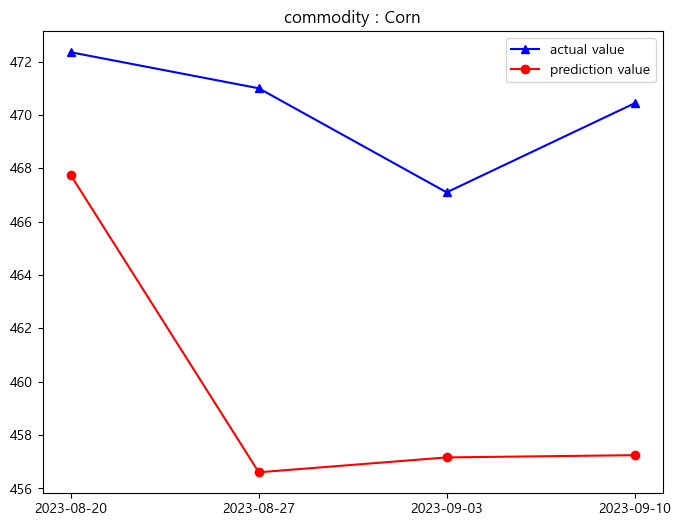

In [16]:
i = 0
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_0 = np.sqrt(MSE_i)
MAPE_0 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_0))
print('MAPE: %.3f' %(MAPE_0)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

RMSE: 28.432
MAPE: 3.589


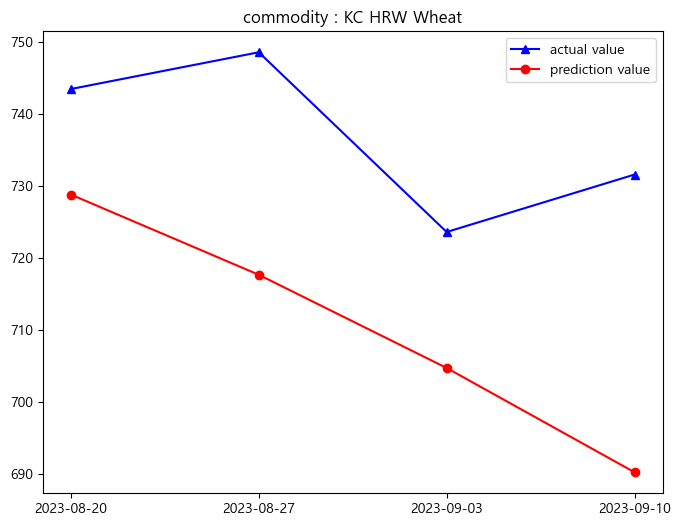

In [17]:
i = 1
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_1 = np.sqrt(MSE_i)
MAPE_1 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_1))
print('MAPE: %.3f' %(MAPE_1)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

RMSE: 91.674
MAPE: 18.437


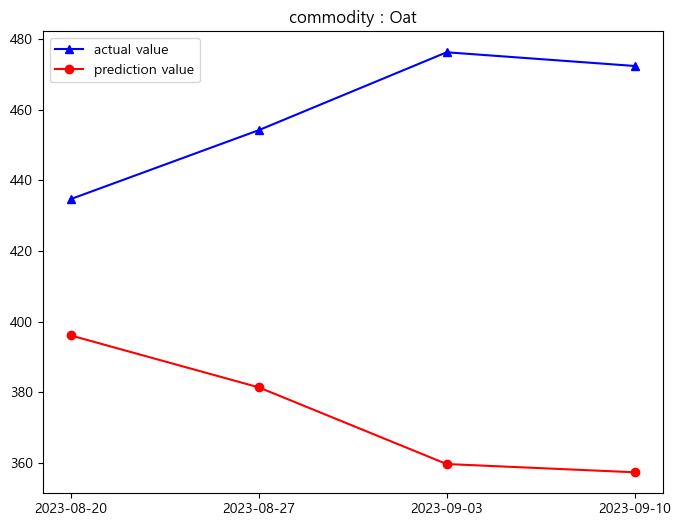

In [18]:
i = 2
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_2 = np.sqrt(MSE_i)
MAPE_2 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_2))
print('MAPE: %.3f' %(MAPE_2)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

RMSE: 191.288
MAPE: 10.168


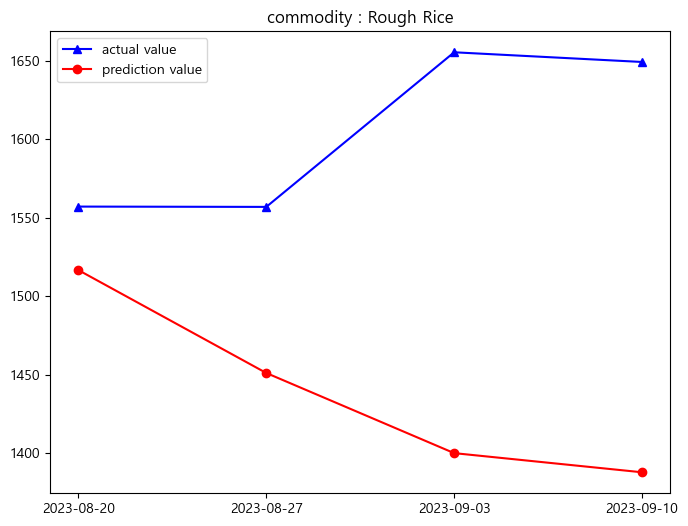

In [19]:
i = 3
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_3 = np.sqrt(MSE_i)
MAPE_3 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_3))
print('MAPE: %.3f' %(MAPE_3)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

RMSE: 48.678
MAPE: 3.348


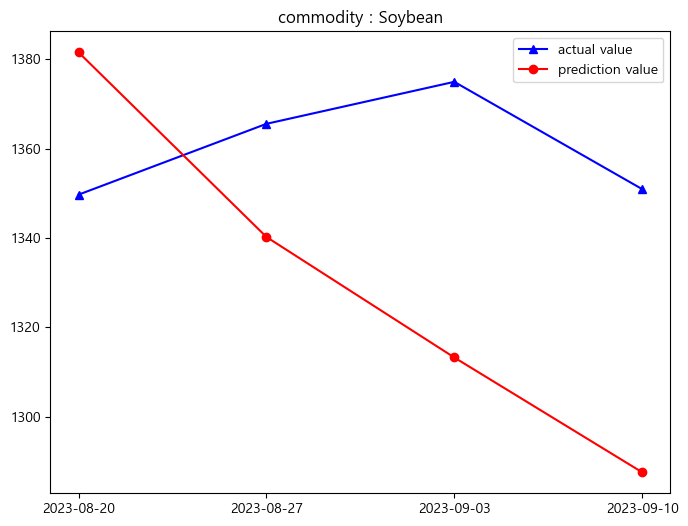

In [20]:
i = 4
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_4 = np.sqrt(MSE_i)
MAPE_4 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_4))
print('MAPE: %.3f' %(MAPE_4)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

RMSE: 5.828
MAPE: 8.085


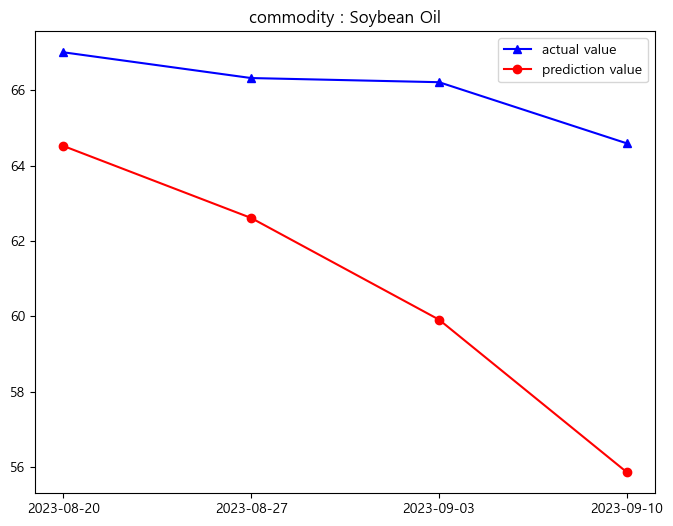

In [21]:
i = 5
commodity_i = df_test_result[df_test_result['commodity_code'] == i]

# prediction evaluation
    
MSE_i = mean_squared_error(commodity_i['actual'], commodity_i['pred'])
RMSE_5 = np.sqrt(MSE_i)
MAPE_5 = cal_MAPE(commodity_i['actual'], commodity_i['pred']) 

print('RMSE: %.3f' %(RMSE_5))
print('MAPE: %.3f' %(MAPE_5)) 

# visualization

date_i = commodity_i['week_last_date']
date_i_formatted = [date.strftime("%Y-%m-%d") for date in date_i]

plt.figure(figsize=(8, 6))
plt.plot(date_i, commodity_i['actual'], label='actual value', color='b', marker='^')
plt.plot(date_i, commodity_i['pred'], label='prediction value', color='r', marker='o')
plt.legend()
plt.xticks(ticks=date_i, labels=date_i_formatted)
plt.title(f"commodity : {mapping[i]}")
plt.show()

In [22]:
print('Total mean RMSE: %.3f' %(np.mean([RMSE_0, RMSE_1, RMSE_2, RMSE_3, RMSE_4, RMSE_5])))
print('Total mean MAPE: %.3f' %(np.mean([MAPE_0, MAPE_1, MAPE_2, MAPE_3, MAPE_4, MAPE_5]))) 

Total mean RMSE: 62.849
Total mean MAPE: 7.645
